# Testing out a model with random walk Poisson parameters

In [1]:
import pandas as pd
import numpy as np
import theano.tensor as tt
import pymc3 as pm
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Read in basic mock data
Each row has:
- a pair of individual IDs for an "A" and "B" individual
- a column for how many rows so far have contained this individual (e.g. a representation of "time" in the sample)
- an "interval" representing a period of observations for each individual (basically make 10 total intervals over the 38 total observations for each individual)

In [3]:
data = pd.read_csv('mock_data.csv')

In [4]:
data.head()

,n_a,n_b,interval_a,interval_b,id_a,id_b
0,0,0,0,0,0,3
1,0,0,0,0,8,16
2,0,0,0,0,7,17
3,0,0,0,0,10,19
4,0,0,0,0,18,4


In [5]:
data.shape

(380, 6)

(My basic definition for interval below:)

In [6]:
#data['interval_a'] = (data.n_a // 4)
#data['interval_b'] = (data.n_b // 4)

In [7]:
data.interval_a.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

### Creating mock data  
I want to model a process where each row has two values, one for each individual, that come from a Poisson process.
Furthermore, each individual has two parameters The Poisson distribution is parameterized such that:
$$X_a \sim Poisson(\theta_a)$$
$$X_b \sim Poisson(\theta_b)$$
Where:
$$log(\theta_a) = add_a + sub_b$$
$$log(\theta_b) = add_b + sub_a$$

That is, each individual has a true "add" rate and "sub(tract)" rate that contributes to their own count value and that of their paired individual. In this example, I'd like these parameters to vary over time according to a random walk. Thus, the add/subtract rates will be unique to each combination of (individual, interval)

Create "True" starting  Poisson rates for each individual

In [8]:
true_add_rates = np.random.gamma(10, 1/8., size=(20,1))
true_sub_rates = np.random.gamma(10, 1/8., size=(20,1))

Now, add a random walk to these parameters for each individual over the 10 total intervals:

In [9]:
att_rw = np.random.normal(0, 0.05, size=(20,9))
def_rw = np.random.normal(0, 0.05, size=(20,9))

In [10]:
interval_add_rates = np.concatenate((true_add_rates, att_rw), axis=1).cumsum(axis=1)
interval_sub_rates = np.concatenate((true_sub_rates, def_rw), axis=1).cumsum(axis=1)

Example of true "add" rate for individual 0, varying over time.

In [11]:
interval_add_rates[0,:]

array([ 0.7330871 ,  0.62427348,  0.71040413,  0.71312737,  0.76179902,
        0.76833135,  0.80889259,  0.76476117,  0.71151382,  0.61701864])

I also impose a sum-to-zero constraint here on each of the add/subtract rates across all of the individuals, for each interval. This is achieved by subtracting the mean from each of the individual parameters. I add the mean back in later when taking poisson draws 

In [12]:
true_add_rates = (interval_add_rates - interval_add_rates.mean(axis=0))

In [13]:
true_sub_rates = (interval_sub_rates - interval_sub_rates.mean(axis=0))

In [14]:
true_add_rates.shape

(20, 10)

Join these true rates for each individual-interval back to the original data with pairs of individuals

In [15]:
full_add_rates = pd.DataFrame(true_add_rates)
full_sub_rates = pd.DataFrame(true_sub_rates)

In [16]:
full_add_rates = full_add_rates.stack()
full_add_rates.index.names = ['full_id', 'interval']
full_add_rates.name = 'true_add'
full_sub_rates = full_sub_rates.stack()
full_sub_rates.index.names = ['full_id', 'interval']
full_sub_rates.name = 'true_sub'

In [17]:
data = pd.merge(data, full_add_rates.to_frame(),
                    how='left', left_on=['id_a','interval_a'],
                    right_index=True)
data = pd.merge(data, full_add_rates.to_frame(),
                    how='left', left_on=['id_b', 'interval_b'],
                    right_index=True)
data = data.rename(columns={'true_add_x': 'true_add_a', 'true_add_y': 'true_add_b'})
data = pd.merge(data, full_sub_rates.to_frame(),
                    how='left', left_on=['id_a','interval_a'],
                    right_index=True)
data = pd.merge(data, full_sub_rates.to_frame(),
                    how='left', left_on=['id_b', 'interval_b'],
                    right_index=True)
data = data.rename(columns={'true_sub_x': 'true_sub_a', 'true_sub_y': 'true_sub_b'})
data = data[[i for i in data.columns if 'full_id' not in i]].copy()

In [18]:
true_add_rates.mean(axis=1)

array([-0.55518725,  0.06094377,  0.28350138, -0.09583855, -0.44010963,
        0.13159133, -0.01521144, -0.47137044, -0.162909  ,  0.38012936,
        0.97410712,  0.5041915 , -0.75094072,  0.42809228, -0.10629827,
       -0.03211416, -0.82190344,  0.58301241,  0.1797391 , -0.07342536])

In [19]:
data.head()

,n_a,n_b,interval_a,interval_b,id_a,id_b,true_add_a,true_add_b,true_sub_a,true_sub_b
0,0,0,0,0,0,3,-0.565807,-0.090804,1.028134,-0.025533
1,0,0,0,0,8,16,-0.235958,-0.730789,0.909008,0.095859
2,0,0,0,0,7,17,-0.576231,0.663638,-0.317331,0.147703
3,0,0,0,0,10,19,0.960896,-0.070490,-0.323154,0.155722
4,0,0,0,0,18,4,0.087794,-0.389996,-0.388655,0.190206


Compute some sample counts to build the model from by combining the true rates in the way described above to get a unique poisson parameter for each combination of teams and intervals. 

In [20]:
data['rate_a'] = np.exp(np.log(1.25) + data.true_add_a + data.true_sub_b)
data['rate_b'] = np.exp(np.log(1.25) + data.true_add_b + data.true_sub_a)

In [21]:
data['value_a'] = data.apply(lambda x: np.random.poisson(x.rate_a), axis=1)
data['value_b'] = data.apply(lambda x: np.random.poisson(x.rate_b), axis=1)

In [22]:
data.head()

,n_a,n_b,interval_a,interval_b,id_a,id_b,true_add_a,true_add_b,true_sub_a,true_sub_b,rate_a,rate_b,value_a,value_b
0,0,0,0,0,0,3,-0.565807,-0.090804,1.028134,-0.025533,0.691981,3.191444,1,1
1,0,0,0,0,8,16,-0.235958,-0.730789,0.909008,0.095859,1.086591,1.493859,0,1
2,0,0,0,0,7,17,-0.576231,0.663638,-0.317331,0.147703,0.814335,1.767295,1,1
3,0,0,0,0,10,19,0.960896,-0.070490,-0.323154,0.155722,3.818134,0.843243,2,0
4,0,0,0,0,18,4,0.087794,-0.389996,-0.388655,0.190206,1.650608,0.573781,1,0


In [23]:
id_a = data.id_a.values
id_b = data.id_b.values
interval_a = data.interval_a.values
interval_b = data.interval_b.values
obs_value_a = data.value_a.astype('int').values
obs_value_b = data.value_b.astype('int').values

In [24]:
rename_map = {i:i.split('_')[0] for i in data.columns if ('_a' in i) or ('_b' in i)}
add_values_1 = data[['interval_b','id_b', 'value_b']].rename(columns=rename_map)
add_values_2 = data[['interval_a','id_a', 'value_a']].rename(columns=rename_map)
sub_values_1 = data[['interval_b','id_b', 'value_a']].rename(columns=rename_map)
sub_values_2 = data[['interval_a','id_a', 'value_b']].rename(columns=rename_map)
full_add_vals = pd.concat([add_values_1, add_values_2],axis=0)
full_sub_vals = pd.concat([sub_values_1, sub_values_2],axis=0)

In [27]:
add_estimate = full_add_vals.groupby(['interval','id']).value.mean().unstack()
sub_estimate = full_sub_vals.groupby(['interval','id']).value.mean().unstack()

In [28]:
add_estimate.shape

(10, 20)

Functions for doing log transformation of thetas for poisson RVs

In [29]:
def a_theta_fn(id_a,
               id_b,
               interval_a,
               interval_b,                                    
               adds_est,
               subs_est,
               intercept):
    log_theta = intercept + \
                adds_est[interval_a, id_a] + \
                subs_est[interval_b, id_b]
    return tt.exp(log_theta)


def b_theta_fn(id_a,
               id_b,
               interval_a,
               interval_b,                                    
               adds_est,
               subs_est,
               intercept):
    log_theta = intercept + \
                adds_est[interval_b, id_b] + \
                subs_est[interval_a, id_a]
    return tt.exp(log_theta)


### Model Specification

Construct model

In [30]:
n_intervals = 10

In [32]:
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=0, sd=1, testval=0.25)
    adds_star = pm.GaussianRandomWalk("adds_star",
                          sd=0.0001,
                          shape=(n_intervals, add_estimate.shape[1]),
                          testval=add_estimate)
    subs_star = pm.GaussianRandomWalk("subs_star",
                          sd=0.0001,
                          shape=(n_intervals, sub_estimate.shape[1]),
                          testval=sub_estimate)
    
    # normalize parameters -sum to zero constraint
    adds_est = pm.Deterministic("adds", adds_star - tt.tile(adds_star.mean(axis=1), (adds_star.shape[1], 1)).T)
    subs_est = pm.Deterministic("subs", subs_star - tt.tile(subs_star.mean(axis=1), (subs_star.shape[1], 1)).T)

    a_dtistic = a_theta_fn(id_a,
                           id_b,
                           interval_a,
                           interval_b,                                    
                           adds_est,
                           subs_est,
                           intercept)

    b_dtistic = b_theta_fn(id_a,
                           id_b,
                           interval_a,
                           interval_b,                                    
                           adds_est,
                           subs_est,
                           intercept)

    a_theta = pm.Deterministic("home_theta", a_dtistic)
    b_theta = pm.Deterministic("away_theta", b_dtistic)

    a_counts = pm.Poisson('a_counts',
                            mu=a_theta,
                            observed=obs_value_a)
    b_counts = pm.Poisson('b_counts',
                            mu=b_theta,
                            observed=obs_value_b)

MCMC sampling

In [33]:
with model:
    step1 = pm.Metropolis()
    trace = pm.sample(10000, step=step1)

100%|██████████| 10500/10500 [00:12<00:00, 860.50it/s]


### Results

This should be 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127864f50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127918090>]], dtype=object)

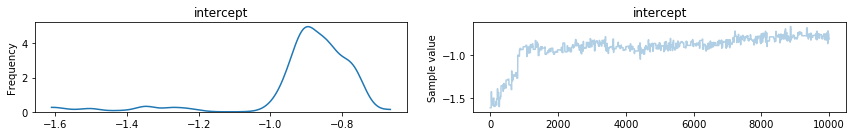

In [34]:
pm.traceplot(trace, varnames=['intercept'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12accac50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12ad39c10>]], dtype=object)

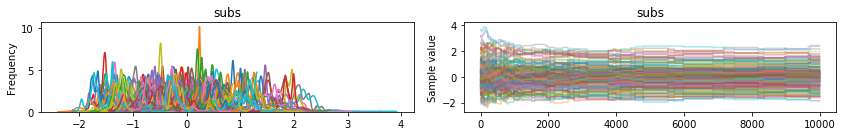

In [35]:
pm.traceplot(trace, varnames=['subs'])

### Examining individual/interval rates from the posteriors

In [36]:
add_samples = pd.DataFrame(trace['adds'].mean(axis=0))
sub_samples = pd.DataFrame(trace['subs'].mean(axis=0))

In [37]:
add_posterior_means = add_samples.stack().swaplevel()
add_posterior_means.index.names = ['full_id', 'interval'] 
sub_posterior_means = sub_samples.stack().swaplevel()
sub_posterior_means.index.names = ['full_id', 'interval'] 

In [38]:
# make a DF with team attacking and defensive strength, indexed by the 0...n-1 team IDs, with the team name added
indiv_params = pd.DataFrame({'add':add_posterior_means,
                               'sub':sub_posterior_means})                


In [39]:
indiv_params.head()

,,add,sub
full_id,interval,,
0,0,-0.805894,0.902967
1,0,-1.407112,-1.091009
2,0,0.456462,-0.310513
3,0,-0.282786,-0.542787
4,0,-0.689741,1.088295


Join these to the true rates to compare

In [40]:
indiv_params = indiv_params.join(full_add_rates, how='left').join(full_sub_rates, how='left')

In [41]:
indiv_params.head(35)

,,add,sub,true_add,true_sub
full_id,interval,,,,
0,0,-0.805894,0.902967,-0.565807,1.028134
1,0,-1.407112,-1.091009,0.054584,-0.094828
2,0,0.456462,-0.310513,0.374870,-0.290390
3,0,-0.282786,-0.542787,-0.090804,-0.025533
4,0,-0.689741,1.088295,-0.389996,0.190206
5,0,0.351690,0.317567,0.075837,-0.131558
6,0,0.037281,-0.018126,-0.026505,0.170707
7,0,-0.189041,-0.607342,-0.576231,-0.317331
8,0,0.087373,1.281420,-0.235958,0.909008


In [42]:
indiv_params[['add','true_add']].corr()

,add,true_add
add,1.000000,0.752817
true_add,0.752817,1.000000


In [43]:
indiv_params[['sub','true_sub']].corr()

,sub,true_sub
sub,1.000000,0.767598
true_sub,0.767598,1.000000


In [44]:
indiv_params.loc[19]['add']

interval
0   -0.821030
1   -0.659618
2   -0.405675
3   -0.197921
4    0.334409
5    0.372244
6    0.082320
7   -0.208276
8   -0.080617
9    0.035490
Name: add, dtype: float64

Compare estimated and true add/sub rates for two different individuals 

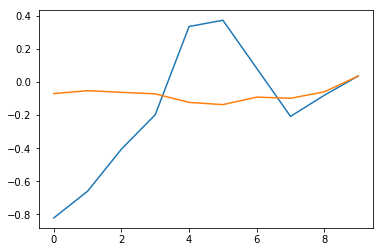

In [45]:
plt.plot(range(0,10),indiv_params.loc[19]['add'])
plt.plot(range(0,10),indiv_params.loc[19]['true_add'])

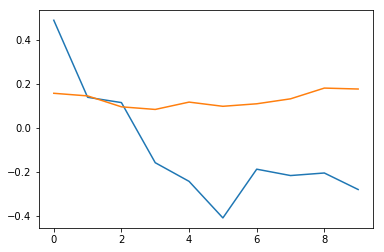

In [46]:
plt.plot(range(0,10),indiv_params.loc[19]['sub'])
plt.plot(range(0,10),indiv_params.loc[19]['true_sub'])